# Define DOTS phantom

Phantom is a sum of ``rectified'' sinc lobes with random centers and vertical offsets.

load packages

In [2]:
import torch
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import qmc

helper functions

In [3]:
def oval(x,x0,k,b,a):
  sincx = torch.sinc(2*torch.pi*k*(x[0]-x0[0]))
  sincy = torch.sinc(2*torch.pi*k*(x[1]-x0[1]))
  return a*torch.nn.functional.relu(sincx*sincy-b)

def phantom(x,x0ar,kar,bar,aar):
  out = torch.zeros_like(x[0])
  for i in range(len(kar)):
    out += oval(x,x0ar[:,i].T,kar[i],bar[i],aar[i])
  return out

# get coordinates for evaluation of the CBNN
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of 0 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(0, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

define phantom

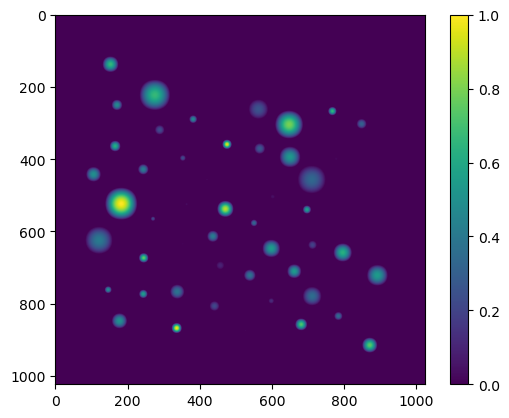

In [ ]:
rng = np.random.default_rng(1)
radius = 0.1
engine = qmc.PoissonDisk(d=2, radius=radius, seed=rng)
sample = engine.random(50)

sample.shape
x0ar = torch.from_numpy(sample.T)

torch.manual_seed(10)
N = len(x0ar.T)
x0ar = 0.1 + 0.8*x0ar
kar = torch.randint(low=2,high=8,size=(N,))
bar = 0.5 + 0.5*torch.rand((N,))
aar = 2 + 3*torch.rand((N,))

n = 1024
coords = get_mgrid(n).T

img = torch.zeros((n,n))
img += phantom(coords,x0ar,kar,bar,aar).view(n,n)

img = img/2.0345
plt.imshow(img,cmap="viridis",vmin=0,vmax=1)
plt.colorbar()
plt.show()


Generate low-pass version

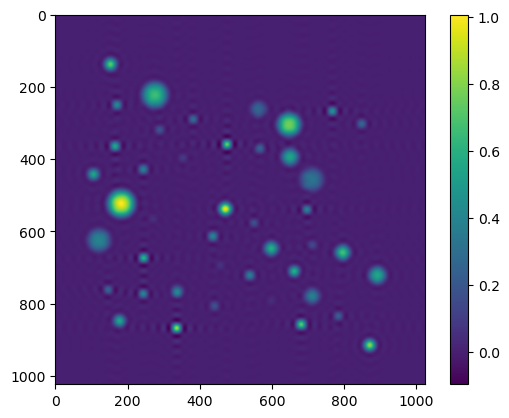

In [22]:
nx = 1024 #recon grid size
Kmax = 35 #max freq in k-data
res = (nx,nx) #image resolution over which to perform FFTs
freq = torch.fft.fftfreq(nx,d=1/nx)
freq_x,freq_y = torch.meshgrid(freq,freq)
mask1 = (torch.max(torch.abs(freq_x),torch.abs(freq_y)) <= Kmax)

kdata = torch.fft.fft2(img,norm="ortho")[mask1]

z = torch.zeros(res, dtype=torch.complex64)
z[mask1] = kdata.flatten()
x0 = torch.real(torch.fft.ifft2(z,norm="ortho"))

plt.imshow(x0,cmap="viridis")
plt.colorbar()
plt.show()

save images

In [23]:
np.save("DOTS_rasterized_1024.npy",img) 
np.save("DOTS_lowpass_1024.npy",x0)